In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_A_over"
plot_title = "train_A_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.309066,0.252632,0.226353,0.252632,0.535912,0.732143,0.326284,0.489139
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.741413,0.689474,0.507001,0.689474,0.857307,0.798838,0.732782,0.594783
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.774347,0.733684,0.552599,0.733684,0.878731,0.815853,0.771136,0.633527
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.788169,0.753684,0.569296,0.753684,0.899047,0.829162,0.812638,0.659955
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.795403,0.763158,0.579367,0.763158,0.908764,0.835767,0.832492,0.674493


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,test,0.552001,0.480670,0.475010,0.480670,0.747693,0.849690,0.611334,0.689439
1,2,test,0.788650,0.760954,0.650412,0.760954,0.914948,0.901152,0.853470,0.781779
2,3,test,0.814874,0.793814,0.684683,0.793814,0.926523,0.913958,0.872179,0.808583
3,4,test,0.824061,0.806701,0.697781,0.806701,0.936527,0.921089,0.889549,0.822228
4,5,test,0.831769,0.815722,0.708280,0.815722,0.942714,0.924719,0.900358,0.831944


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/302:,Train,Loss,=,1.217,Valid,Loss,=,1.120,ETA,=,5.09h
1,Epoch,"1/40,",Batch,20/302:,Train,Loss,=,1.121,Valid,Loss,=,1.094,ETA,=,4.70h
2,Epoch,"1/40,",Batch,30/302:,Train,Loss,=,1.072,Valid,Loss,=,1.026,ETA,=,4.21h
3,Epoch,"1/40,",Batch,40/302:,Train,Loss,=,1.032,Valid,Loss,=,0.997,ETA,=,4.03h
4,Epoch,"1/40,",Batch,50/302:,Train,Loss,=,0.993,Valid,Loss,=,0.941,ETA,=,3.88h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.217,1.120
20,1,20,1.121,1.094
30,1,30,1.072,1.026
40,1,40,1.032,0.997
50,1,50,0.993,0.941


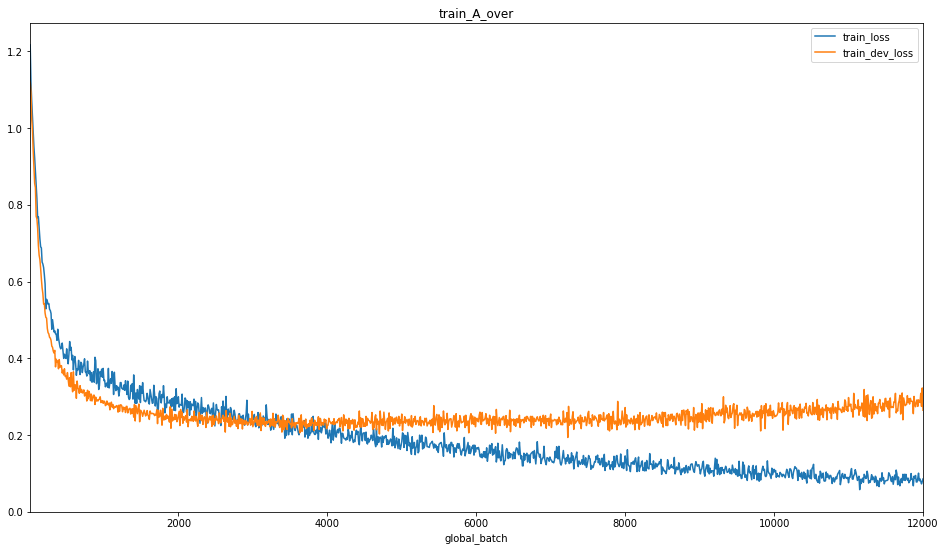

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.6895,0.6210
2,0.4270,0.3670
3,0.3670,0.3080
4,0.3365,0.2805
5,0.3180,0.2675


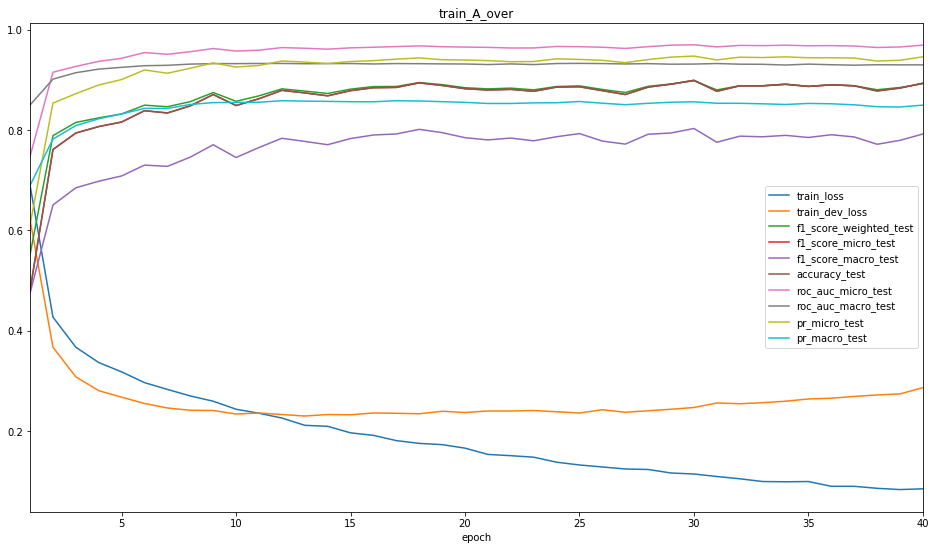

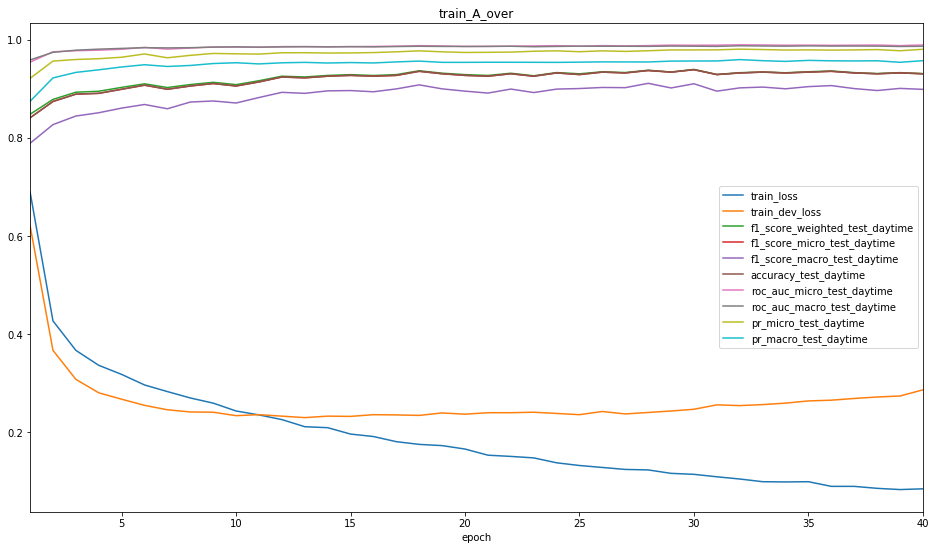

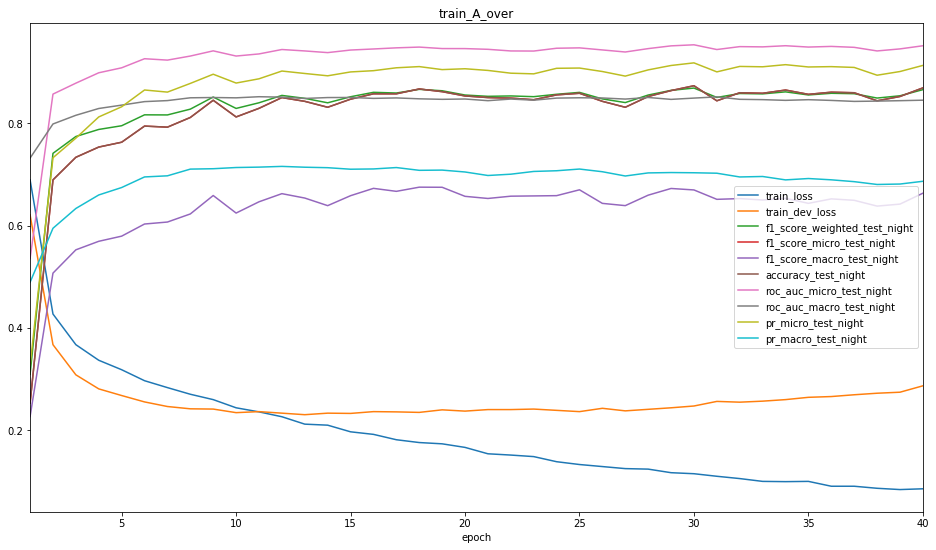

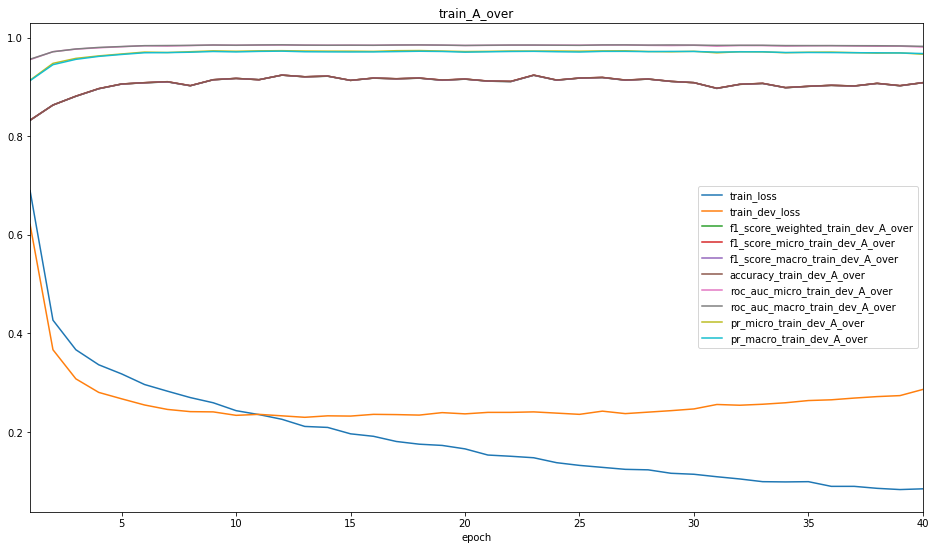

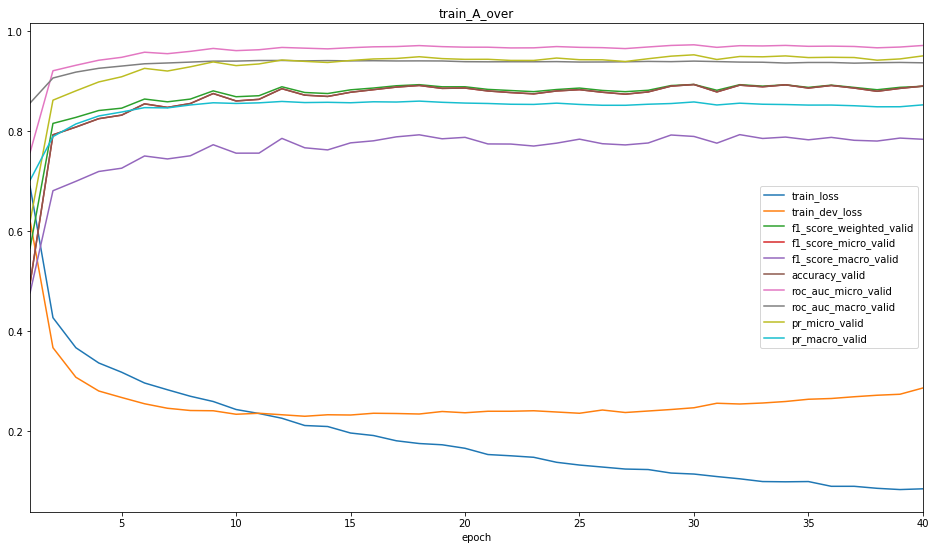

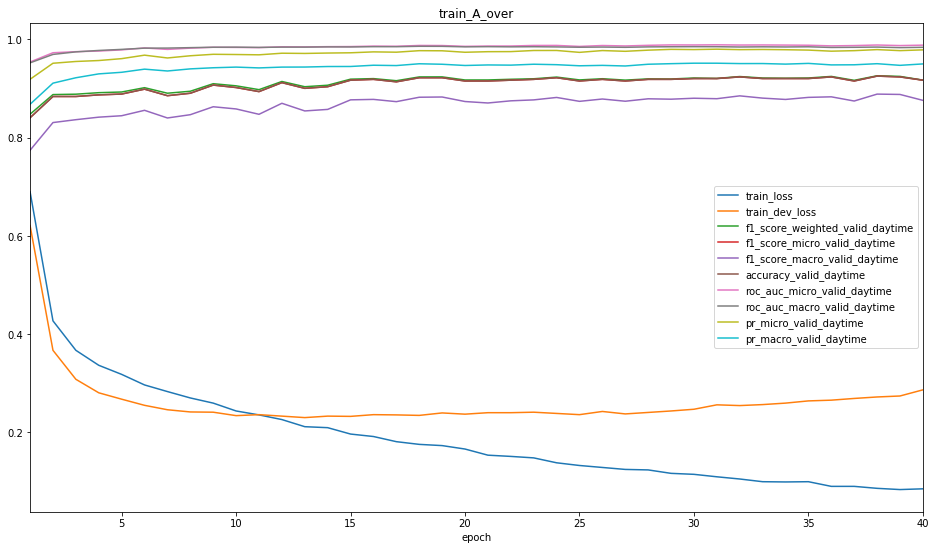

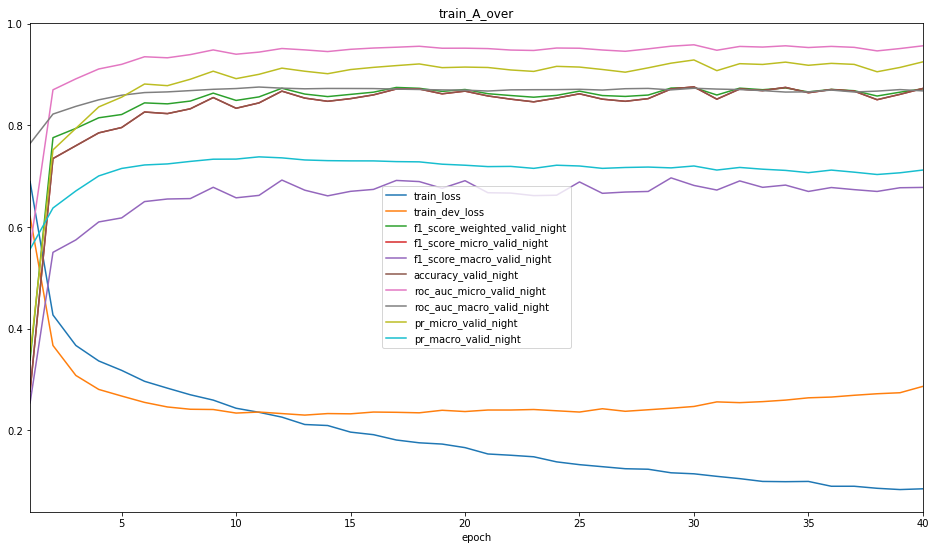

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)